# **0) Install dependencies**

In [ ]:
!pip -q install torch torchvision torchaudio
!pip -q install sentencepiece tqdm pandas nltk
# COCO caption metrics (CIDEr, SPICE). If it fails, we gracefully fall back.
!pip -q install git+https://github.com/salaniz/pycocoevalcap.git || true

import nltk
nltk.download('punkt')


  Preparing metadata (setup.py) ... done


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# **1) Mount Drive & set paths**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, re, glob, pandas as pd
from pathlib import Path

# ---- Your layout (as you stated) ----
DATA_ROOT = "/content/drive/My Drive/CVPR"
IMG_DIR   = os.path.join(DATA_ROOT, "BNLIT")
TRAIN_ANN = os.path.join(DATA_ROOT, "Train-Annotation.txt")
TEST_ANN  = os.path.join(DATA_ROOT, "Test-Annotation.txt")

for p in [IMG_DIR, TRAIN_ANN, TEST_ANN]:
    assert os.path.exists(p), f"Missing path: {p}"

print("Folders & files are ready ✅")
print("Images dir:", IMG_DIR)
print("Train ann:", TRAIN_ANN)
print("Test ann:", TEST_ANN)


Mounted at /content/drive
Folders & files are ready ✅
Images dir: /content/drive/My Drive/CVPR/BNLIT
Train ann: /content/drive/My Drive/CVPR/Train-Annotation.txt
Test ann: /content/drive/My Drive/CVPR/Test-Annotation.txt


# **2) Parse annotation files → DataFrames**

In [ ]:
import os, re, glob

def parse_annotations(file_path, img_dir, verbose=False, limit=None):
    rows, missing = [], []
    with open(file_path, 'r', encoding='utf-8') as f:
        for ln, line in enumerate(f, 1):
            s = line.strip()
            if not s: continue
            parts = s.split('\t', 1) if '\t' in s else s.split(maxsplit=1)
            if len(parts) < 2:
                if verbose: print(f"⚠️ Skipping line {ln} (bad format): {s[:100]}")
                continue
            fname_raw, caption = parts[0].strip(), parts[1].strip()
            fname = os.path.basename(fname_raw)
            cand = os.path.join(img_dir, fname)
            if os.path.exists(cand):
                rows.append((cand, caption))
            else:
                stem = os.path.splitext(fname)[0]
                ms = glob.glob(os.path.join(img_dir, stem + '.*'))
                ms = [m for m in ms if m.lower().endswith(('.jpg','.jpeg','.png'))]
                if len(ms) >= 1:
                    rows.append((ms[0], caption))
                else:
                    missing.append(fname)
            if limit and len(rows) >= limit:
                break
    if verbose and missing:
        print(f"⚠️ Missing {len(missing)} images (showing first 10):", missing[:10])
    return pd.DataFrame(rows, columns=['image_path','caption_bn'])

train_df = parse_annotations(TRAIN_ANN, IMG_DIR, verbose=True)
test_df  = parse_annotations(TEST_ANN,  IMG_DIR, verbose=True)

print(f"✅ Train size: {len(train_df)}")
print(f"✅ Test  size: {len(test_df)}")
display(train_df.head())
display(test_df.head())


⚠️ Skipping line 5838 (bad format): ji_ts_tf_945.jpg#পানি
⚠️ Skipping line 6892 (bad format): ji_ts_tf_1999.jpg#মহাখালি
⚠️ Skipping line 6893 (bad format): ji_ts_tf_2000.jpg#মহাখালি
⚠️ Skipping line 6895 (bad format): ji_ts_tf_2002.jpg#মহাখালি
⚠️ Missing 3261 images (showing first 10): ['img_0000037.jpeg', 'img_0000149.jpeg', 'img_0000152.jpeg', 'img_0000175.jpeg', 'img_0000180.jpeg', 'img_0000187.jpeg', 'img_0000213.jpeg', 'img_0000280.jpeg', 'img_0000290.jpeg', 'img_0000343.jpeg']
✅ Train size: 4978
✅ Test  size: 500


,image_path,caption_bn
0,/content/drive/My Drive/CVPR/BNLIT/img_0000001...,# একটি শহরে আমরা অনেক ধরনের ভবন দেখতে পাই।
1,/content/drive/My Drive/CVPR/BNLIT/img_0000002...,# একটি ক্ষেত্র পাশে একটি গেট।
2,/content/drive/My Drive/CVPR/BNLIT/img_0000003...,# গ্রামে হাঁটা দুই শিশু।
3,/content/drive/My Drive/CVPR/BNLIT/img_0000004...,# কিছু লোক নদী পার করছে।
4,/content/drive/My Drive/CVPR/BNLIT/img_0000005...,# এক কৃষক ক্ষেত্র কাজ করছে।


,image_path,caption_bn
0,/content/drive/My Drive/CVPR/BNLIT/1.png,#একটি ছেলে ব্রিজের রেলিংয়ে দাড়িয়ে আছে।
1,/content/drive/My Drive/CVPR/BNLIT/2.png,#একটি ছেলে দেয়ালে হেলান দিয়ে দাড়িয়ে আছে।
2,/content/drive/My Drive/CVPR/BNLIT/3.png,#দুইটি ছেলে একটি গরু নিয়ে ব্রিজের উপর দাড়িয়ে আছে।
3,/content/drive/My Drive/CVPR/BNLIT/4.png,#চারজন ছেলে আড্ডায় কথোপকথন করে হাসছে।
4,/content/drive/My Drive/CVPR/BNLIT/5.png,#তিনজন ছেলে সার্ট এর দোকানে দাড়িয়ে আছে।


# **3) Train / load SentencePiece tokenizer**

In [ ]:
import sentencepiece as spm, os

SPM_MODEL = "/content/spm_bnlit.model"

if not os.path.exists(SPM_MODEL):
    corpus_path = "/content/corpus.txt"
    with open(corpus_path,"w",encoding="utf-8") as f:
        for c in train_df['caption_bn'].tolist():
            f.write((c or "").strip()+"\n")
    try_vocab = 6000
    spm.SentencePieceTrainer.Train(
        f"--input={corpus_path} --model_prefix=/content/spm_bnlit "
        f"--vocab_size={try_vocab} --character_coverage=0.9995 --model_type=bpe"
    )

tok = spm.SentencePieceProcessor(model_file=SPM_MODEL)
PAD, BOS, EOS = 0, 1, 2

def encode_caption(text, max_len=40):
    ids = [BOS] + tok.encode(text or "", out_type=int)[:max_len-2] + [EOS]
    if len(ids) < max_len:
        ids += [PAD]*(max_len-len(ids))
    return ids

def decode_ids(ids):
    ids = [i for i in ids if i not in (PAD,BOS,EOS)]
    return tok.decode(ids)

VOCAB_SIZE = tok.get_piece_size() + 3  # PAD,BOS,EOS reserved
print("Vocab size (+special):", VOCAB_SIZE)


Vocab size (+special): 6003


# 4) Dataset, transforms, and dataloaders

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

IMG_SIZE = 224
MAX_LEN  = 40

img_tf_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
])
img_tf_eval = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
])

class CapDS(Dataset):
    def __init__(self, df, tf, max_len=MAX_LEN):
        self.df, self.tf, self.max_len = df.reset_index(drop=True), tf, max_len
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        p = self.df.iloc[i]
        img = Image.open(p.image_path).convert('RGB')
        img = self.tf(img)
        ids = torch.tensor(encode_caption(p.caption_bn, self.max_len), dtype=torch.long)
        return img, ids, p.image_path

def collate(batch):
    imgs, ids, paths = zip(*batch)
    return torch.stack(imgs,0), torch.stack(ids,0), list(paths)

train_loader = DataLoader(CapDS(train_df, img_tf_train), batch_size=32, shuffle=True, num_workers=2, collate_fn=collate)
val_loader   = DataLoader(CapDS(test_df,  img_tf_eval),  batch_size=32, shuffle=False, num_workers=2, collate_fn=collate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device


'cuda'

# **5) Model: ViT encoder, CAF, Transformer decoder, CaptionModel**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.vision_transformer import vit_b_16, ViT_B_16_Weights

# -----------------------------
# Vision Encoder (ViT tokens)
# -----------------------------
class ViTEncoder(nn.Module):
    def __init__(self, d_model=384, freeze_layers=0):
        super().__init__()
        self.vit = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
        self.proj = nn.Linear(self.vit.hidden_dim, d_model) if self.vit.hidden_dim != d_model else nn.Identity()
        # optionally freeze first N ViT blocks
        for i, blk in enumerate(self.vit.encoder.layers):
            if i < freeze_layers:
                for p in blk.parameters():
                    p.requires_grad = False

    def forward(self, x):
        x = self.vit._process_input(x)      # patchify
        n = x.size(0)
        cls = self.vit.class_token.expand(n, -1, -1)
        x = torch.cat((cls, x), dim=1)
        x = x + self.vit.encoder.pos_embedding
        x = self.vit.encoder.dropout(x)
        x = self.vit.encoder.layers(x)
        x = self.vit.encoder.ln(x)          # [B, 1+L, H]
        V = x[:, 1:, :]                     # drop CLS → [B, L, H]
        return self.proj(V)                 # [B, L, D]

# ------------------------------------------------------------
# Gated Cross-Attention Fusion (CAF) over visual tokens only
# V' = V + g * MHA(LN(V), LN(V), LN(V))   (g: scalar or tokenwise)
# ------------------------------------------------------------
class CAF(nn.Module):
    def __init__(self, d_model=384, n_heads=6, dropout=0.1, tokenwise=False, residual_drop=0.1):
        super().__init__()
        self.ln = nn.LayerNorm(d_model)
        self.mha = nn.MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)
        self.tokenwise = tokenwise
        if tokenwise:
            self.gate = nn.Sequential(nn.Linear(2*d_model, d_model), nn.Sigmoid())
        else:
            self.gate = nn.Sequential(nn.Linear(2*d_model, d_model), nn.ReLU(),
                                      nn.Linear(d_model, 1), nn.Sigmoid())
        self.resdrop = nn.Dropout(residual_drop) if residual_drop and residual_drop > 0 else nn.Identity()

    def forward(self, V):
        X = self.ln(V)
        C, _ = self.mha(X, X, X, need_weights=False)      # [B, L, D]
        meanC, meanV = C.mean(1), V.mean(1)               # [B, D], [B, D]
        u = torch.cat([meanC, meanV], dim=-1)
        if self.tokenwise:
            u = u.unsqueeze(1).expand(-1, V.size(1), -1)  # [B, L, 2D]
            g = self.gate(u)                              # [B, L, D]
        else:
            g = self.gate(u).unsqueeze(1)                 # [B, 1, 1]
        return V + self.resdrop(g * C)

# simple stack to match the diagram's two CAF blocks
class CAFStack(nn.Module):
    def __init__(self, layers=2, d_model=384, n_heads=6, dropout=0.1, tokenwise=False, residual_drop=0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            CAF(d_model=d_model, n_heads=n_heads, dropout=dropout,
                tokenwise=tokenwise, residual_drop=residual_drop)
            for _ in range(layers)
        ])
    def forward(self, V):
        for blk in self.layers:
            V = blk(V)
        return V

# -----------------------------------------
# Transformer Decoder (Nd layers as diagram)
# -----------------------------------------
class DecoderLayer(nn.Module):
    def __init__(self, d_model=384, heads=6, ff=4.0, drop=0.1):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.sa  = nn.MultiheadAttention(d_model, heads, dropout=drop, batch_first=True)  # masked self-attn
        self.ln2 = nn.LayerNorm(d_model)
        self.ca  = nn.MultiheadAttention(d_model, heads, dropout=drop, batch_first=True)  # cross-attn over V'
        self.ln3 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, int(ff*d_model)), nn.GELU(), nn.Dropout(drop),
            nn.Linear(int(ff*d_model), d_model)
        )
        self.drop = nn.Dropout(drop)

    def forward(self, x, mem, tgt_mask=None, pad_mask=None, need_attn=False):
        y, _   = self.sa(self.ln1(x), self.ln1(x), self.ln1(x),
                         attn_mask=tgt_mask, key_padding_mask=pad_mask, need_weights=False)
        x = x + self.drop(y)
        y, attn = self.ca(self.ln2(x), mem, mem, need_weights=need_attn)
        x = x + self.drop(y)
        y = self.ffn(self.ln3(x))
        x = x + self.drop(y)
        return x, attn

class TransformerDecoder(nn.Module):
    def __init__(self, vocab, d_model=384, heads=6, layers=4, pad_id=0, drop=0.1, max_len=512):
        super().__init__()
        self.emb = nn.Embedding(vocab, d_model, padding_idx=pad_id)
        self.pos = nn.Embedding(max_len, d_model)
        self.layers = nn.ModuleList([DecoderLayer(d_model, heads, 4.0, drop) for _ in range(layers)])
        self.ln = nn.LayerNorm(d_model)
        self.lm = nn.Linear(d_model, vocab)
        self.pad_id = pad_id
        self.d_model = d_model

    def forward(self, ids, mem, return_attn=False):
        B, T = ids.shape
        pos_ids = torch.arange(T, device=ids.device).unsqueeze(0).expand(B, T)
        x = self.emb(ids) * (self.d_model ** 0.5) + self.pos(pos_ids)
        causal = torch.triu(torch.ones(T, T, device=ids.device, dtype=torch.bool), 1)  # masked self-attn (causal)
        pad_mask = (ids == self.pad_id)                                                # padding mask
        last_attn = None
        for lyr in self.layers:
            x, attn = lyr(x, mem, tgt_mask=causal, pad_mask=pad_mask, need_attn=return_attn)
            if return_attn:
                last_attn = attn
        x = self.ln(x)
        logits = self.lm(x)
        return (logits, last_attn) if return_attn else logits

# -----------------------------------------
# Full Model: ViT → CAF ×2 → Decoder
# -----------------------------------------
class CaptionModel(nn.Module):
    def __init__(self, vocab_size, d_model=384, heads=6, dec_layers=4,
                 caf_tokenwise=False, caf_layers=2, caf_dropout=0.1, caf_resdrop=0.1,
                 vit_freeze=0, pad_id=0):
        super().__init__()
        self.enc = ViTEncoder(d_model=d_model, freeze_layers=vit_freeze)
        self.caf = CAFStack(layers=caf_layers, d_model=d_model, n_heads=heads,
                            dropout=caf_dropout, tokenwise=caf_tokenwise, residual_drop=caf_resdrop)
        self.dec = TransformerDecoder(vocab=vocab_size, d_model=d_model, heads=heads,
                                      layers=dec_layers, pad_id=pad_id)

    def encode_imgs(self, images):
        V = self.enc(images)     # [B, L, D]
        Vp = self.caf(V)         # apply two CAF blocks → [B, L, D]
        return Vp

    def forward(self, images, tgt_in, return_attn=False):
        mem = self.encode_imgs(images)
        return self.dec(tgt_in, mem, return_attn=return_attn)


# **6) Metrics, decoding, and training utilities**

In [ ]:
import math, json, numpy as np, os
from tqdm import tqdm
from torch.amp import autocast, GradScaler

# BN-friendly light tokenizer for BLEU/METEOR
import re
_punct = r'([।!?,;:()"“”\'\-–—])'
def bn_tokenize(s: str):
    s = re.sub(_punct, r' \1 ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s.split()

from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score

def local_bleu_meteor(list_refs, list_hyps):
    refs_tok = [[bn_tokenize(r)] for r in list_refs]
    hyps_tok = [bn_tokenize(h) for h in list_hyps]
    smoothie = SmoothingFunction().method4
    b1 = corpus_bleu(refs_tok, hyps_tok, weights=(1,0,0,0), smoothing_function=smoothie)
    b2 = corpus_bleu(refs_tok, hyps_tok, weights=(0.5,0.5,0,0), smoothing_function=smoothie)
    b3 = corpus_bleu(refs_tok, hyps_tok, weights=(0.33,0.33,0.33,0), smoothing_function=smoothie)
    b4 = corpus_bleu(refs_tok, hyps_tok, weights=(0.25,0.25,0.25,0.25), smoothing_function=smoothie)
    mets = [meteor_score([bn_tokenize(r) for r in [ref]], bn_tokenize(h))
            for ref, h in zip(list_refs, list_hyps)]
    return {"BLEU-1":b1,"BLEU-2":b2,"BLEU-3":b3,"BLEU-4":b4,"METEOR":float(np.mean(mets))}

# COCO eval with fallback
def coco_eval(preds, refs):
    """
    preds: [{"image_id":str, "caption":str}, ...]
    refs : [{"image_id":str, "caption":str}, ...]
    """
    from collections import defaultdict
    ref_by = defaultdict(list)
    hyp_by = {}
    for r in refs: ref_by[r["image_id"]].append(r["caption"])
    for p in preds: hyp_by[p["image_id"]] = p["caption"]
    keys = [k for k in ref_by.keys() if k in hyp_by]
    local = local_bleu_meteor([ref_by[k][0] for k in keys], [hyp_by[k] for k in keys])
    try:
        from pycocoevalcap.eval import COCOEvalCap
        from pycocoevalcap.coco import COCO
        import tempfile
        gt_list = []
        for k in keys:
            for i, c in enumerate(ref_by[k]):
                gt_list.append({"image_id": k, "id": f"{k}_{i}", "caption": c})
        with tempfile.NamedTemporaryFile(mode='w', delete=False, suffix='.json') as gtf, \
             tempfile.NamedTemporaryFile(mode='w', delete=False, suffix='.json') as prf:
            json.dump({"annotations": gt_list}, gtf); gtf.flush()
            json.dump([{"image_id": k, "caption": hyp_by[k]} for k in keys], prf); prf.flush()
            coco = COCO(gtf.name)
            cocoRes = coco.loadRes(prf.name)
            cocoEval = COCOEvalCap(coco, cocoRes)
            cocoEval.params['image_id'] = keys
            cocoEval.evaluate()
            out = {**local, **{k: float(v) for k,v in cocoEval.eval.items()}}
            return out
    except Exception as e:
        local["_warning"] = f"COCO eval unavailable ({e}); reporting BLEU/METEOR only."
        return local

# beam search
def generate_beam(model, img_tensor, max_len=40, beam=5, lp=0.8):
    model.eval()
    with torch.no_grad():
        mem = model.encode_imgs(img_tensor.unsqueeze(0).to(device))  # [1,L,D]
        beams = [(torch.tensor([BOS], device=device), 0.0)]
        for _ in range(max_len-1):
            cand = []
            for seq, score in beams:
                if seq[-1].item() == EOS:
                    cand.append((seq, score)); continue
                logits = model.dec(seq.unsqueeze(0), mem)[0, -1]
                logp = F.log_softmax(logits, dim=-1)
                topk = torch.topk(logp, beam)
                for idx, val in zip(topk.indices, topk.values):
                    new_seq = torch.cat([seq, idx.view(1)])
                    norm = (len(new_seq)**lp)
                    cand.append((new_seq, (score+float(val))/norm))
            cand.sort(key=lambda x: x[1], reverse=True)
            beams = cand[:beam]
        best = beams[0][0].tolist()
    ids = [i for i in best if i not in (PAD,BOS,EOS)]
    return tok.decode(ids)

def train_one_epoch(model, loader, optimizer, scaler, epoch, vocab_size):
    model.train()
    crit = nn.CrossEntropyLoss(ignore_index=PAD, label_smoothing=0.1)
    total = 0.0
    pbar = tqdm(loader, desc=f"Train {epoch}")
    for imgs, ids, _ in pbar:
        imgs, ids = imgs.to(device), ids.to(device)
        tgt_in, tgt_out = ids[:,:-1], ids[:,1:]
        optimizer.zero_grad(set_to_none=True)
        with autocast(device_type='cuda', dtype=torch.float16, enabled=(device=='cuda')):
            logits = model(imgs, tgt_in)     # [B,T-1,V]
            loss = crit(logits.reshape(-1, vocab_size), tgt_out.reshape(-1))
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer); scaler.update()
        total += float(loss)
        pbar.set_postfix(loss=float(loss))
    return total/len(loader)

def evaluate_model(model, loader, beam=5, max_len=40):
    preds, refs = [], []
    model.eval()
    with torch.no_grad():
        for imgs, ids, paths in tqdm(loader, desc="Eval"):
            imgs = imgs.to(device)
            for i in range(imgs.size(0)):
                hyp = generate_beam(model, imgs[i].cpu(), max_len=max_len, beam=beam)
                img_id = paths[i]
                preds.append({"image_id": img_id, "caption": hyp})
                ref = decode_ids(ids[i].tolist())
                refs.append({"image_id": img_id, "caption": ref})
    return coco_eval(preds, refs)

# download for METEOR
import nltk
nltk.download('wordnet')

# --- Early Stopping helper (maximize a metric; saves best checkpoint) ---
class EarlyStopping:
    def __init__(self, patience=6, min_delta=1e-3, mode='max', ckpt_path="/content/best_caption_model.pt"):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode  # 'max' or 'min'
        self.ckpt_path = ckpt_path
        self.best = -float('inf') if mode == 'max' else float('inf')
        self.bad = 0

    def _improved(self, val):
        if self.mode == 'max':
            return val > (self.best + self.min_delta)
        else:
            return val < (self.best - self.min_delta)

    def step(self, value, model=None, extra=None):
        if self._improved(value):
            self.best, self.bad = value, 0
            if model is not None:
                torch.save({"model": model.state_dict(),
                            "best_metric": value,
                            "extra": extra}, self.ckpt_path)
            return False  # keep training
        else:
            self.bad += 1
            return self.bad >= self.patience  # stop if patience exceeded


[nltk_data] Downloading package wordnet to /root/nltk_data...


# **7) Train the main model & evaluate**

In [ ]:
from torch.optim import AdamW

cfg_main = dict(
    d_model=384, heads=6, dec_layers=4, caf_tokenwise=False, vit_freeze=0,
    lr=3e-4, epochs=50, batch=32, beam=5, max_len=40
)

model = CaptionModel(
    vocab_size=VOCAB_SIZE,
    d_model=cfg_main['d_model'],
    heads=cfg_main['heads'],
    dec_layers=cfg_main['dec_layers'],
    caf_tokenwise=cfg_main['caf_tokenwise'],
    vit_freeze=cfg_main['vit_freeze'],
    pad_id=PAD
).to(device)

optimizer = AdamW(model.parameters(), lr=cfg_main['lr'], weight_decay=0.05)
scaler = GradScaler('cuda' if device=='cuda' else 'cpu')

early = EarlyStopping(patience=6, min_delta=1e-3, mode='max',
                      ckpt_path="/content/best_caption_model.pt")

for ep in range(cfg_main['epochs']):
    avg_loss = train_one_epoch(model, train_loader, optimizer, scaler, ep, VOCAB_SIZE)
    # evaluate every epoch (beam=3 is faster for validation)
    val_metrics = evaluate_model(model, val_loader, beam=3, max_len=cfg_main['max_len'])
    meteor = float(val_metrics.get("METEOR", 0.0))
    print(f"Epoch {ep} avg loss: {avg_loss:.4f} | val METEOR: {meteor:.4f}")

    if early.step(meteor, model=model, extra={"epoch": ep, "loss": avg_loss, "metrics": val_metrics}):
        print(f"Early stopping triggered at epoch {ep}. Best METEOR={early.best:.4f}")
        break

# Load best checkpoint and compute final metrics with full beam
state = torch.load("/content/best_caption_model.pt", map_location=device)
model.load_state_dict(state["model"])
metrics_main = evaluate_model(model, val_loader, beam=cfg_main['beam'], max_len=cfg_main['max_len'])
print("Main model best metrics:")
for k, v in metrics_main.items():
    print(f"{k}: {v:.4f}" if isinstance(v, (int, float)) else f"{k} {v}")


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:01<00:00, 196MB/s]
Train 0:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-1714302672.py:104: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  total += float(loss)
Eval: 100%|██████████| 16/16 [02:59<00:00, 11.19s/it]


Epoch 0 avg loss: 4.3947 | val METEOR: 0.3308


Eval: 100%|██████████| 16/16 [00:59<00:00,  3.69s/it]


Epoch 1 avg loss: 3.4517 | val METEOR: 0.3912


Eval: 100%|██████████| 16/16 [00:59<00:00,  3.74s/it]


Epoch 2 avg loss: 3.2106 | val METEOR: 0.3912


Eval: 100%|██████████| 16/16 [00:57<00:00,  3.59s/it]


Epoch 3 avg loss: 3.0501 | val METEOR: 0.3912


Eval: 100%|██████████| 16/16 [01:00<00:00,  3.79s/it]


Epoch 4 avg loss: 2.9311 | val METEOR: 0.3912


Eval: 100%|██████████| 16/16 [01:02<00:00,  3.92s/it]


Epoch 5 avg loss: 2.8314 | val METEOR: 0.3730


Eval: 100%|██████████| 16/16 [01:01<00:00,  3.87s/it]


Epoch 6 avg loss: 2.7452 | val METEOR: 0.4027


Eval: 100%|██████████| 16/16 [01:01<00:00,  3.87s/it]


Epoch 7 avg loss: 2.6689 | val METEOR: 0.4030


Eval: 100%|██████████| 16/16 [01:04<00:00,  4.02s/it]


Epoch 8 avg loss: 2.6000 | val METEOR: 0.3926


Eval: 100%|██████████| 16/16 [01:06<00:00,  4.14s/it]


Epoch 9 avg loss: 2.5445 | val METEOR: 0.4261


Eval: 100%|██████████| 16/16 [01:02<00:00,  3.90s/it]


Epoch 10 avg loss: 2.4939 | val METEOR: 0.3696


Eval: 100%|██████████| 16/16 [01:02<00:00,  3.91s/it]


Epoch 11 avg loss: 2.4443 | val METEOR: 0.2973


Eval: 100%|██████████| 16/16 [00:59<00:00,  3.71s/it]


Epoch 12 avg loss: 2.3981 | val METEOR: 0.3724


Eval: 100%|██████████| 16/16 [01:01<00:00,  3.83s/it]


Epoch 13 avg loss: 2.3549 | val METEOR: 0.3678


Eval: 100%|██████████| 16/16 [01:07<00:00,  4.19s/it]


Epoch 14 avg loss: 2.3214 | val METEOR: 0.4522


Eval: 100%|██████████| 16/16 [01:03<00:00,  3.96s/it]


Epoch 15 avg loss: 2.2835 | val METEOR: 0.3360


Eval: 100%|██████████| 16/16 [01:02<00:00,  3.91s/it]


Epoch 16 avg loss: 2.2522 | val METEOR: 0.3628


Eval: 100%|██████████| 16/16 [01:03<00:00,  3.97s/it]


Epoch 17 avg loss: 2.2221 | val METEOR: 0.3762


Eval: 100%|██████████| 16/16 [01:10<00:00,  4.40s/it]


Epoch 18 avg loss: 2.1919 | val METEOR: 0.3930


Eval: 100%|██████████| 16/16 [01:04<00:00,  4.05s/it]


Epoch 19 avg loss: 2.1675 | val METEOR: 0.3326


Eval: 100%|██████████| 16/16 [01:02<00:00,  3.93s/it]


Epoch 20 avg loss: 2.1396 | val METEOR: 0.3365
Early stopping triggered at epoch 20. Best METEOR=0.4522


Eval: 100%|██████████| 16/16 [01:41<00:00,  6.35s/it]


Main model best metrics:
BLEU-1: 0.4467
BLEU-2: 0.3150
BLEU-3: 0.2012
BLEU-4: 0.0827
METEOR: 0.4514
_warning COCO eval unavailable (No module named 'pycocoevalcap.coco'); reporting BLEU/METEOR only.


# **8) Ablations: alt encoders & quick experiments**

In [ ]:
import pandas as pd
from torchvision.models import resnet101, ResNet101_Weights

class ResNetEncoder(nn.Module):
    def __init__(self, d_model=384):
        super().__init__()
        rn = resnet101(weights=ResNet101_Weights.IMAGENET1K_V1)
        rn.fc = nn.Identity()
        self.backbone = rn
        self.proj = nn.Linear(2048, d_model)
    def forward(self, x):
        g = self.backbone(x)             # [B,2048]
        return self.proj(g).unsqueeze(1) # [B,1,D]

class CaptionModelAbl(nn.Module):
    """Pluggable encoder: 'resnet' or 'vit'; CAF optional; gate: scalar|token."""
    def __init__(self, vocab_size, encoder='vit', caf=True, gate='scalar',
                 d_model=384, heads=6, dec_layers=4, vit_freeze=0):
        super().__init__()
        if encoder == 'vit':
            self.enc = ViTEncoder(d_model=d_model, freeze_layers=vit_freeze)
            self.is_vit = True
        elif encoder == 'resnet':
            self.enc = ResNetEncoder(d_model=d_model)
            self.is_vit = False
        else:
            raise ValueError("encoder must be 'vit' or 'resnet'")
        self.caf = CAF(d_model, heads, tokenwise=(gate=='token')) if (caf and self.is_vit) else None
        self.dec = TransformerDecoder(vocab=vocab_size, d_model=d_model, heads=heads,
                                      layers=dec_layers, pad_id=PAD)

    def forward(self, images, tgt_in):
        V = self.enc(images)                # [B,L,D] (L=1 for ResNet)
        Vp = self.caf(V) if self.caf is not None else V
        return self.dec(tgt_in, Vp)

    def encode_imgs(self, images):
        V = self.enc(images)
        return self.caf(V) if self.caf is not None else V

def run_experiment(name, encoder='vit', caf=True, gate='scalar', img_size=224,
                   epochs=10, beam=3, batch=16, d_model=384, heads=6, dec_layers=4, vit_freeze=0):
    from torchvision import transforms
    from torch.utils.data import DataLoader

    tf_train = transforms.Compose([
        transforms.Resize((img_size,img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
    ])
    tf_eval  = transforms.Compose([
        transforms.Resize((img_size,img_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
    ])
    train_loader2 = DataLoader(CapDS(train_df, tf_train), batch_size=batch, shuffle=True, num_workers=2, collate_fn=collate)
    val_loader2   = DataLoader(CapDS(test_df,  tf_eval),  batch_size=batch, shuffle=False, num_workers=2, collate_fn=collate)

    m = CaptionModelAbl(VOCAB_SIZE, encoder=encoder, caf=caf, gate=gate,
                        d_model=d_model, heads=heads, dec_layers=dec_layers, vit_freeze=vit_freeze).to(device)
    opt = AdamW(m.parameters(), lr=3e-4, weight_decay=0.05)
    sc  = GradScaler('cuda' if device=='cuda' else 'cpu')

    early = EarlyStopping(patience=2, min_delta=5e-4, mode='max',
                          ckpt_path=f"/content/best_{name}.pt")

    for ep in range(epochs):
        los = train_one_epoch(m, train_loader2, opt, sc, ep, VOCAB_SIZE)
        valm = evaluate_model(m, val_loader2, beam=beam, max_len=MAX_LEN)
        mete = float(valm.get("METEOR", 0.0))
        print(f"[{name}] epoch {ep} loss {los:.4f} | val METEOR {mete:.4f}")
        if early.step(mete, model=m, extra={"epoch": ep, "loss": los, "metrics": valm}):
            print(f"[{name}] early stop @ {ep}, best METEOR={early.best:.4f}")
            break

    # load best before returning
    m.load_state_dict(torch.load(f"/content/best_{name}.pt", map_location=device)["model"])
    metrics = evaluate_model(m, val_loader2, beam=beam, max_len=MAX_LEN)
    print(f"[{name}] metrics:", {k:(round(v,4) if isinstance(v,float) else v) for k,v in metrics.items()})
    return metrics

# Define experiments (you can raise epochs if you want)
experiments = [
    dict(name="baseline_resnet", encoder="resnet", caf=False, gate="scalar", img_size=224, epochs=6, beam=3, batch=16),
    dict(name="vit_only",       encoder="vit",    caf=False, gate="scalar", img_size=224, epochs=6, beam=3, batch=16),
    dict(name="vit_caf_scalar", encoder="vit",    caf=True,  gate="scalar", img_size=224, epochs=6, beam=3, batch=16),
    dict(name="vit_caf_token",  encoder="vit",    caf=True,  gate="token",  img_size=224, epochs=6, beam=3, batch=16),
]


# **9) Run ablation loop & save results**

In [ ]:
rows = []

for cfg in experiments:
    try:
        m = run_experiment(**cfg)
        row = {"name": cfg["name"], **{k: (float(v) if isinstance(v,(int,float)) else v) for k,v in m.items()}}
        rows.append(row)
        df = pd.DataFrame(rows)
        display(df)
    except Exception as e:
        print("Experiment failed:", cfg["name"], e)

if rows:
    df = pd.DataFrame(rows)
    out_path = "/content/ablation_results.csv"
    df.to_csv(out_path, index=False)
    print("Saved:", out_path)


Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


100%|██████████| 171M/171M [00:00<00:00, 209MB/s]
Eval: 100%|██████████| 32/32 [00:56<00:00,  1.76s/it]


[baseline_resnet] epoch 0 loss 4.1077 | val METEOR 0.3890


Eval: 100%|██████████| 32/32 [00:58<00:00,  1.83s/it]


[baseline_resnet] epoch 1 loss 3.3350 | val METEOR 0.3902


Eval: 100%|██████████| 32/32 [00:57<00:00,  1.78s/it]


[baseline_resnet] epoch 2 loss 3.1074 | val METEOR 0.3904


Eval: 100%|██████████| 32/32 [00:57<00:00,  1.80s/it]


[baseline_resnet] epoch 3 loss 2.9498 | val METEOR 0.3571
[baseline_resnet] early stop @ 3, best METEOR=0.3902


Eval: 100%|██████████| 32/32 [00:58<00:00,  1.82s/it]


[baseline_resnet] metrics: {'BLEU-1': 0.39, 'BLEU-2': 0.2818, 'BLEU-3': 0.2017, 'BLEU-4': 0.0858, 'METEOR': 0.3902, '_warning': "COCO eval unavailable (No module named 'pycocoevalcap.coco'); reporting BLEU/METEOR only."}


,name,BLEU-1,BLEU-2,BLEU-3,BLEU-4,METEOR,_warning
0,baseline_resnet,0.390012,0.281766,0.201696,0.08579,0.390186,COCO eval unavailable (No module named 'pycoco...


Eval: 100%|██████████| 32/32 [00:55<00:00,  1.75s/it]


[vit_only] epoch 0 loss 4.0956 | val METEOR 0.3308


Eval: 100%|██████████| 32/32 [00:59<00:00,  1.85s/it]


[vit_only] epoch 1 loss 3.3229 | val METEOR 0.3912


Eval: 100%|██████████| 32/32 [00:58<00:00,  1.81s/it]


[vit_only] epoch 2 loss 3.0974 | val METEOR 0.3912


Eval: 100%|██████████| 32/32 [01:01<00:00,  1.91s/it]


[vit_only] epoch 3 loss 2.9370 | val METEOR 0.4030


Eval: 100%|██████████| 32/32 [00:59<00:00,  1.87s/it]


[vit_only] epoch 4 loss 2.8174 | val METEOR 0.3981


Eval: 100%|██████████| 32/32 [00:58<00:00,  1.84s/it]


[vit_only] epoch 5 loss 2.7117 | val METEOR 0.3657
[vit_only] early stop @ 5, best METEOR=0.4030


Eval: 100%|██████████| 32/32 [01:00<00:00,  1.90s/it]


[vit_only] metrics: {'BLEU-1': 0.4281, 'BLEU-2': 0.3025, 'BLEU-3': 0.2088, 'BLEU-4': 0.0867, 'METEOR': 0.403, '_warning': "COCO eval unavailable (No module named 'pycocoevalcap.coco'); reporting BLEU/METEOR only."}


,name,BLEU-1,BLEU-2,BLEU-3,BLEU-4,METEOR,_warning
0,baseline_resnet,0.390012,0.281766,0.201696,0.085790,0.390186,COCO eval unavailable (No module named 'pycoco...
1,vit_only,0.428141,0.302528,0.208776,0.086701,0.403044,COCO eval unavailable (No module named 'pycoco...


Eval: 100%|██████████| 32/32 [00:58<00:00,  1.84s/it]


[vit_caf_scalar] epoch 0 loss 4.0939 | val METEOR 0.3912


Eval: 100%|██████████| 32/32 [00:55<00:00,  1.74s/it]


[vit_caf_scalar] epoch 1 loss 3.3355 | val METEOR 0.3879


Eval: 100%|██████████| 32/32 [00:59<00:00,  1.85s/it]


[vit_caf_scalar] epoch 2 loss 3.0980 | val METEOR 0.3912
[vit_caf_scalar] early stop @ 2, best METEOR=0.3912


Eval: 100%|██████████| 32/32 [00:58<00:00,  1.82s/it]


[vit_caf_scalar] metrics: {'BLEU-1': 0.3907, 'BLEU-2': 0.2825, 'BLEU-3': 0.2024, 'BLEU-4': 0.086, 'METEOR': 0.3912, '_warning': "COCO eval unavailable (No module named 'pycocoevalcap.coco'); reporting BLEU/METEOR only."}


,name,BLEU-1,BLEU-2,BLEU-3,BLEU-4,METEOR,_warning
0,baseline_resnet,0.390012,0.281766,0.201696,0.085790,0.390186,COCO eval unavailable (No module named 'pycoco...
1,vit_only,0.428141,0.302528,0.208776,0.086701,0.403044,COCO eval unavailable (No module named 'pycoco...
2,vit_caf_scalar,0.390738,0.282524,0.202384,0.086024,0.391151,COCO eval unavailable (No module named 'pycoco...


Eval: 100%|██████████| 32/32 [00:58<00:00,  1.84s/it]


[vit_caf_token] epoch 0 loss 4.0870 | val METEOR 0.3916


Eval: 100%|██████████| 32/32 [00:58<00:00,  1.84s/it]


[vit_caf_token] epoch 1 loss 3.3386 | val METEOR 0.3912


Eval: 100%|██████████| 32/32 [00:58<00:00,  1.81s/it]


[vit_caf_token] epoch 2 loss 3.1066 | val METEOR 0.1025
[vit_caf_token] early stop @ 2, best METEOR=0.3916


Eval: 100%|██████████| 32/32 [00:59<00:00,  1.84s/it]


[vit_caf_token] metrics: {'BLEU-1': 0.391, 'BLEU-2': 0.2831, 'BLEU-3': 0.2033, 'BLEU-4': 0.0903, 'METEOR': 0.3916, '_warning': "COCO eval unavailable (No module named 'pycocoevalcap.coco'); reporting BLEU/METEOR only."}


,name,BLEU-1,BLEU-2,BLEU-3,BLEU-4,METEOR,_warning
0,baseline_resnet,0.390012,0.281766,0.201696,0.085790,0.390186,COCO eval unavailable (No module named 'pycoco...
1,vit_only,0.428141,0.302528,0.208776,0.086701,0.403044,COCO eval unavailable (No module named 'pycoco...
2,vit_caf_scalar,0.390738,0.282524,0.202384,0.086024,0.391151,COCO eval unavailable (No module named 'pycoco...
3,vit_caf_token,0.391012,0.283097,0.203264,0.090332,0.391643,COCO eval unavailable (No module named 'pycoco...


Saved: /content/ablation_results.csv


# *Implementation of Bangla Image to Caption Paper*

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet101, ResNet101_Weights

# ---------- Positional encoding (1D sinusoid over flattened H*W tokens) ----------
class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 10000, dropout: float = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)  # [max_len, d_model]

    def forward(self, x):
        # x: [B, L, D]
        L = x.size(1)
        x = x + self.pe[:L].unsqueeze(0)  # broadcast over batch
        return self.dropout(x)

# ---------- ResNet101 feature-map encoder + TransformerEncoder over tokens ----------
class ResNetTxEncoder(nn.Module):
    """
    ResNet101 backbone (features before avgpool) -> [B,C,H,W] -> flatten to [B,L,C]
    -> linear proj to D -> sinusoidal pos enc -> TransformerEncoder layers -> [B,L,D]
    """
    def __init__(self, d_model=384, n_heads=6, n_layers=2, dim_ff=1024, drop=0.1):
        super().__init__()
        rn = resnet101(weights=ResNet101_Weights.IMAGENET1K_V1)
        # keep everything up to the final conv feature map
        self.cnn = nn.Sequential(
            rn.conv1, rn.bn1, rn.relu, rn.maxpool,
            rn.layer1, rn.layer2, rn.layer3, rn.layer4
        )
        c_out = 2048
        self.proj = nn.Linear(c_out, d_model)
        self.pos = SinusoidalPositionalEncoding(d_model, dropout=drop)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads, dim_feedforward=dim_ff,
            dropout=drop, batch_first=True, activation='gelu'
        )
        self.tx = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.ln_out = nn.LayerNorm(d_model)

    @torch.no_grad()
    def _features(self, x):
        # x: [B,3,H,W] -> [B,C,H',W']
        f = self.cnn(x)
        return f

    def forward(self, x):
        # CNN features
        f = self._features(x)             # [B, C, H, W]
        B, C, H, W = f.shape
        L = H * W
        tokens = f.permute(0, 2, 3, 1).reshape(B, L, C)  # [B, L, C]
        x = self.proj(tokens)                            # [B, L, D]
        x = self.pos(x)                                  # add sinusoidal PE
        x = self.tx(x)                                   # Transformer encoder
        x = self.ln_out(x)                               # [B, L, D]
        return x

# ---------- Decoder is your existing TransformerDecoder (already defined) ----------

class PaperCaptionModel(nn.Module):
    """
    Full model matching the paper:
    ResNet101 + TransformerEncoder  -->  TransformerDecoder
    """
    def __init__(self, vocab_size, d_model=384, heads=6, enc_layers=2, enc_ff=1024,
                 dec_layers=4, drop=0.1, pad_id=0):
        super().__init__()
        self.enc = ResNetTxEncoder(d_model=d_model, n_heads=heads,
                                   n_layers=enc_layers, dim_ff=enc_ff, drop=drop)
        self.dec = TransformerDecoder(vocab=vocab_size, d_model=d_model, heads=heads,
                                      layers=dec_layers, pad_id=pad_id, drop=drop)

    def encode_imgs(self, images):
        return self.enc(images)

    def forward(self, images, tgt_in, return_attn=False):
        mem = self.encode_imgs(images)  # [B,L,D]
        return self.dec(tgt_in, mem, return_attn=return_attn)


In [ ]:
# === Paper model config (match your main settings where sensible) ===
cfg_paper = dict(
    d_model=384, heads=6,
    enc_layers=2, enc_ff=1024,     # Transformer-Encoder over ResNet tokens
    dec_layers=4,                  # Transformer-Decoder depth
    drop=0.1,
    lr=3e-4, epochs=50, batch=32,  # epochs will be cut short by early stopping
    beam=5, max_len=40
)

# Build the paper model (requires PaperCaptionModel defined earlier)
paper_model = PaperCaptionModel(
    vocab_size=VOCAB_SIZE,
    d_model=cfg_paper['d_model'],
    heads=cfg_paper['heads'],
    enc_layers=cfg_paper['enc_layers'],
    enc_ff=cfg_paper['enc_ff'],
    dec_layers=cfg_paper['dec_layers'],
    drop=cfg_paper['drop'],
    pad_id=PAD
).to(device)

paper_optimizer = AdamW(paper_model.parameters(), lr=cfg_paper['lr'], weight_decay=0.05)
paper_scaler    = GradScaler('cuda' if device=='cuda' else 'cpu')

# Early stopping (maximize METEOR), separate checkpoint from main model
paper_early = EarlyStopping(
    patience=6, min_delta=1e-3, mode='max',
    ckpt_path="/content/best_paper_caption_model.pt"
)


In [ ]:
for ep in range(cfg_paper['epochs']):
    avg_loss = train_one_epoch(paper_model, train_loader, paper_optimizer, paper_scaler, ep, VOCAB_SIZE)
    # Evaluate every epoch; beam=3 is faster for validation
    val_metrics = evaluate_model(paper_model, val_loader, beam=3, max_len=cfg_paper['max_len'])
    meteor = float(val_metrics.get("METEOR", 0.0))
    print(f"[Paper] Epoch {ep} avg loss: {avg_loss:.4f} | val METEOR: {meteor:.4f}")

    if paper_early.step(meteor, model=paper_model,
                        extra={"epoch": ep, "loss": avg_loss, "metrics": val_metrics}):
        print(f"[Paper] Early stopping at epoch {ep}. Best METEOR={paper_early.best:.4f}")
        break

# Load best checkpoint and compute final metrics with full beam (same as main model)
state = torch.load("/content/best_paper_caption_model.pt", map_location=device)
paper_model.load_state_dict(state["model"])

metrics_paper = evaluate_model(paper_model, val_loader, beam=cfg_paper['beam'], max_len=cfg_paper['max_len'])
print("Paper model best metrics:")
for k, v in metrics_paper.items():
    print(f"{k}: {v:.4f}" if isinstance(v, (int, float)) else f"{k} {v}")


Eval: 100%|██████████| 16/16 [00:59<00:00,  3.71s/it]


[Paper] Epoch 0 avg loss: 4.4025 | val METEOR: 0.3912


Eval: 100%|██████████| 16/16 [00:59<00:00,  3.73s/it]


[Paper] Epoch 1 avg loss: 3.4617 | val METEOR: 0.3308


Eval: 100%|██████████| 16/16 [00:58<00:00,  3.66s/it]


[Paper] Epoch 2 avg loss: 3.2185 | val METEOR: 0.3912


Eval: 100%|██████████| 16/16 [00:59<00:00,  3.72s/it]


[Paper] Epoch 3 avg loss: 3.0579 | val METEOR: 0.3912


Eval: 100%|██████████| 16/16 [01:01<00:00,  3.83s/it]


[Paper] Epoch 4 avg loss: 2.9447 | val METEOR: 0.3912


Eval: 100%|██████████| 16/16 [01:06<00:00,  4.14s/it]


[Paper] Epoch 5 avg loss: 2.8457 | val METEOR: 0.3194


Eval: 100%|██████████| 16/16 [00:58<00:00,  3.64s/it]


[Paper] Epoch 6 avg loss: 2.7628 | val METEOR: 0.3912
[Paper] Early stopping at epoch 6. Best METEOR=0.3912


Eval: 100%|██████████| 16/16 [01:30<00:00,  5.65s/it]


Paper model best metrics:
BLEU-1: 0.3907
BLEU-2: 0.2825
BLEU-3: 0.2024
BLEU-4: 0.0860
METEOR: 0.3912
_warning COCO eval unavailable (No module named 'pycocoevalcap.coco'); reporting BLEU/METEOR only.


# ***Final Result***

In [ ]:
import os
import pandas as pd
import numpy as np

# ---- Keep only these columns ----
STD_COLS = ["name", "BLEU-1", "BLEU-2", "BLEU-3", "BLEU-4", "METEOR"]

def to_row(name, metrics: dict):
    row = {"name": name}
    for k in ["BLEU-1","BLEU-2","BLEU-3","BLEU-4","METEOR"]:
        row[k] = float(metrics.get(k, np.nan)) if isinstance(metrics.get(k, None), (int,float)) else np.nan
    return row

# ---- Load ablation results (if available) ----
abl_path = "/content/ablation_results.csv"
if os.path.exists(abl_path):
    ablation_df = pd.read_csv(abl_path)
    # Filter only BLEU-1..4 and METEOR
    keep_cols = [c for c in STD_COLS if c in ablation_df.columns]
    if "name" not in keep_cols and "name" in ablation_df.columns:
        keep_cols = ["name"] + keep_cols
    ablation_df = ablation_df[keep_cols]
else:
    ablation_df = pd.DataFrame(columns=STD_COLS)

# ---- Main model row ----
main_row = to_row("main_model", metrics_main)
rows = [main_row]

# ---- Paper model row ----
if 'metrics_paper' in globals():
    paper_row = to_row("paper_resnet_txenc", metrics_paper)
    rows.append(paper_row)
else:
    ckpt_path = "/content/best_paper_caption_model.pt"
    if os.path.exists(ckpt_path):
        try:
            import torch
            state = torch.load(ckpt_path, map_location=device)
            cfg = globals().get('cfg_paper', dict(d_model=384, heads=6, enc_layers=2, enc_ff=1024, dec_layers=4, drop=0.1))
            paper_model_tmp = PaperCaptionModel(
                vocab_size=VOCAB_SIZE,
                d_model=cfg.get('d_model',384),
                heads=cfg.get('heads',6),
                enc_layers=cfg.get('enc_layers',2),
                enc_ff=cfg.get('enc_ff',1024),
                dec_layers=cfg.get('dec_layers',4),
                drop=cfg.get('drop',0.1),
                pad_id=PAD
            ).to(device)
            paper_model_tmp.load_state_dict(state["model"])
            metrics_paper = evaluate_model(paper_model_tmp, val_loader, beam=5, max_len=40)
            paper_row = to_row("paper_resnet_txenc", metrics_paper)
            rows.append(paper_row)
        except Exception as e:
            print(f"[Info] Could not auto-evaluate paper model from checkpoint: {e}")

tail_df = pd.DataFrame(rows)

# ---- Combine ----
combined = pd.concat([ablation_df, tail_df], ignore_index=True)

# ---- Round ----
for c in ["BLEU-1","BLEU-2","BLEU-3","BLEU-4","METEOR"]:
    if c in combined.columns:
        combined[c] = combined[c].astype(float).round(4)

# ---- Sort by METEOR ----
if "METEOR" in combined.columns:
    combined = combined.sort_values(by="METEOR", ascending=False, na_position="last").reset_index(drop=True)

# ---- Display & Save ----
display(combined)
out_path = "/content/all_results.csv"
combined.to_csv(out_path, index=False)
print("Saved:", out_path)


,name,BLEU-1,BLEU-2,BLEU-3,BLEU-4,METEOR
0,main_model,0.4467,0.3150,0.2012,0.0827,0.4514
1,vit_only,0.4281,0.3025,0.2088,0.0867,0.4030
2,vit_caf_token,0.3910,0.2831,0.2033,0.0903,0.3916
3,vit_caf_scalar,0.3907,0.2825,0.2024,0.0860,0.3912
4,paper_resnet_txenc,0.3907,0.2825,0.2024,0.0860,0.3912
5,baseline_resnet,0.3900,0.2818,0.2017,0.0858,0.3902


Saved: /content/all_results.csv


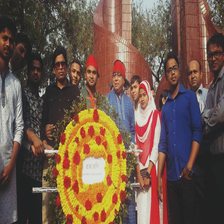


True Caption: #কয়েকজন লোক ফুলের তোরা হাতে দাড়িয়ে আছে।
Generated Caption: #একটি মেয়ে দাড়িয়ে আছে।
BLEU-1: 0.2195
BLEU-2: 0.1735
BLEU-3: 0.0978
BLEU-4: 0.0665
--------------------------------------------------


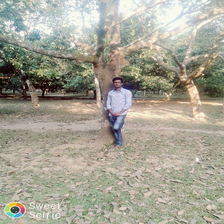


True Caption: #একটি ছেলে দাড়িয়ে আছে।
Generated Caption: #একটি মেয়ে দাড়িয়ে আছে।
BLEU-1: 0.6000
BLEU-2: 0.3873
BLEU-3: 0.2036
BLEU-4: 0.1341
--------------------------------------------------


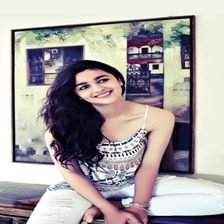


True Caption: #একটি  মেয়ে বসে আছে।
Generated Caption: #একটি মেয়ে দাড়িয়ে আছে।
BLEU-1: 0.6000
BLEU-2: 0.3873
BLEU-3: 0.2036
BLEU-4: 0.1341
--------------------------------------------------


In [ ]:
from PIL import ImageFont, ImageDraw, Image
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import random

# Load the best paper model
state = torch.load("/content/best_paper_caption_model.pt", map_location=device)
paper_model.load_state_dict(state["model"])
paper_model.eval()

# Select a few random images from the test set
num_images_to_show = 3  # You can change this number
random_indices = random.sample(range(len(test_df)), num_images_to_show)

for i in random_indices:
    img_path = test_df.iloc[i]['image_path']
    true_caption = test_df.iloc[i]['caption_bn']

    # Load and preprocess the image
    img = Image.open(img_path).convert('RGB')
    img_tensor = img_tf_eval(img).to(device)

    # Generate caption
    generated_caption = generate_beam(paper_model, img_tensor.cpu(), max_len=cfg_paper['max_len'], beam=cfg_paper['beam'])

    # Display the image
    img_np = cv2.imread(img_path)
    cv2_imshow(img_np)

    # Print captions below the image
    print(f"\nTrue Caption: {true_caption}")
    print(f"Generated Caption: {generated_caption}")

    # Calculate and print BLEU score (using nltk)
    from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
    from nltk.tokenize import word_tokenize

    # Tokenize captions
    reference = [bn_tokenize(true_caption)] # reference must be a list of tokenized sentences
    candidate = bn_tokenize(generated_caption)

    # Calculate BLEU scores
    smoothie = SmoothingFunction().method4
    bleu1 = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0), smoothing_function=smoothie)
    bleu2 = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie)
    bleu3 = sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie)
    bleu4 = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)

    print(f"BLEU-1: {bleu1:.4f}")
    print(f"BLEU-2: {bleu2:.4f}")
    print(f"BLEU-3: {bleu3:.4f}")
    print(f"BLEU-4: {bleu4:.4f}")

    print("-" * 50) # Separator for multiple images